<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# AI in Finance

**Workshop at Texas State University (October 2023)**

**_Simulating Financial Time Series Data_**

Dr. Yves J. Hilpisch | The Python Quants GmbH | http://tpq.io

## Generated Data

### Noisy Data

In [3]:
class ActionSpace:
    def sample(self):
        return random.randint(0, 1)

In [4]:
import numpy as np
import pandas as pd
from numpy.random import default_rng

In [5]:
rng = default_rng()

In [6]:
class NoisyData:
    url = '../sources/eod_prices.csv'
    def __init__(self, symbol, feature, n_features=4,
                 min_accuracy=0.485, noise=True,
                 noise_std=0.001):
        self.symbol = symbol
        self.feature = feature
        self.n_features = n_features
        self.noise = noise  # <2>
        self.noise_std = noise_std  # <3>
        self.action_space = ActionSpace()
        self.min_accuracy = min_accuracy
        self._get_data()
        self._prepare_data()
    def _get_data(self):
        self.raw = pd.read_csv(self.url,
                index_col=0, parse_dates=True)

In [7]:
class NoisyData(NoisyData):
    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol]).dropna()
        if self.noise:
            std = self.data.mean() * self.noise_std
            self.data[self.symbol] = (self.data[self.symbol] +
                rng.normal(0, std, len(self.data)))
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data.dropna(inplace=True)
        mi, ma = self.data.max(), self.data.min()
        self.data_ = (self.data - mi) / (ma - mi)
    def reset(self):
        if self.noise:
            self._prepare_data()
        self.bar = self.n_features
        self.treward = 0
        state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return state, {}

In [8]:
class NoisyData(NoisyData):
    def step(self, action):
        if action == self.data['d'].iloc[self.bar]:
            correct = True
        else:
            correct = False
        reward = 1 if correct else 0 
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.n_features)
        if self.bar >= len(self.data):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and
              self.bar > self.n_features + 15):
            done = True
        else:
            done = False
        next_state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return next_state, reward, done, False, {}

In [9]:
fin = NoisyData(symbol='AAPL', feature='AAPL',
                noise=True, noise_std=0.005)

In [10]:
fin.reset()

(array([0.99590071, 0.99872974, 0.98995453, 0.99632775]), {})

In [11]:
fin.reset()

(array([0.99525121, 0.99820303, 0.99854023, 0.99684739]), {})

In [12]:
fin = NoisyData('AAPL', 'r', n_features=4,
                noise=True, noise_std=0.025)

In [13]:
fin.reset()

(array([ 0.63848595,  0.28394726,  0.7405041 , -0.        ]), {})

In [14]:
fin.reset()

(array([0.74660863, 0.59021026, 0.48809094, 0.13160266]), {})

In [15]:
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

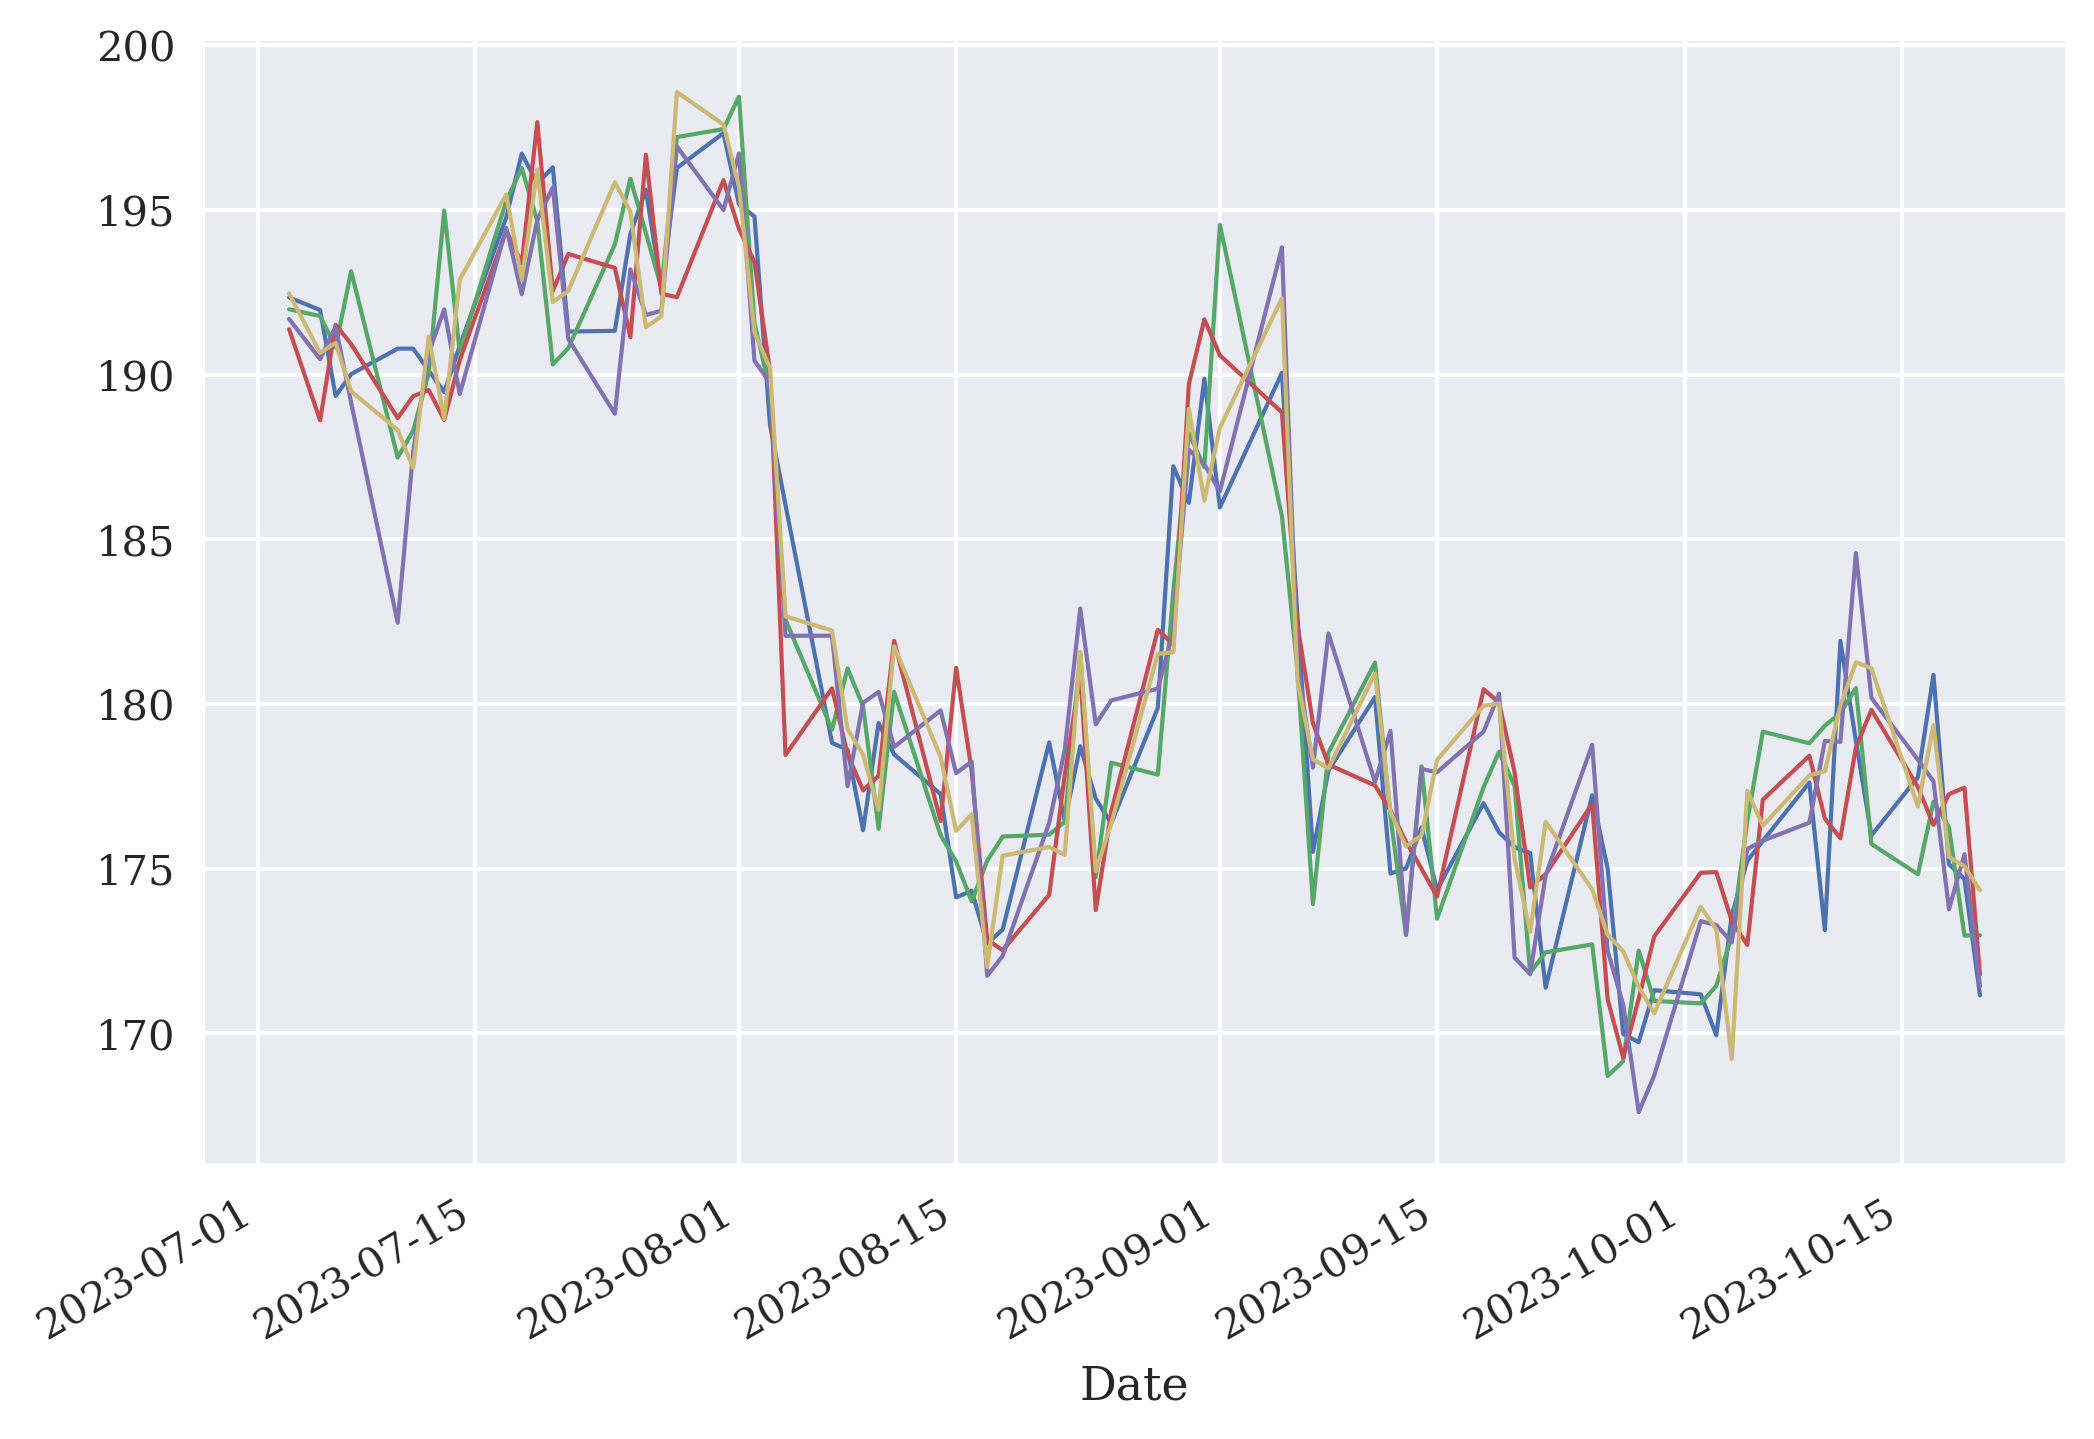

In [16]:
for _ in range(5):
    fin.reset()
    fin.data[fin.symbol].loc['2023-7-1':].plot(lw=1)

### Simulated Data

In [19]:
class Simulation:
    def __init__(self, symbol, feature, n_features,
                 start, end, periods,
                 min_accuracy=0.525, x0=100,
                 kappa=1, theta=100, sigma=0.2,
                 normalize=True, new=False):
        self.symbol = symbol
        self.feature = feature
        self.n_features = n_features
        self.start = start
        self.end = end
        self.periods = periods
        self.x0 = x0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.min_accuracy = min_accuracy
        self.normalize = normalize
        self.new = new
        self.action_space = ActionSpace()
        self._simulate_data()
        self._prepare_data()

In [20]:
import math
class Simulation(Simulation):
    def _simulate_data(self):
        index = pd.date_range(start=self.start,
                    end=self.end, periods=self.periods)
        s = [self.x0]  # <1>
        dt = (index[-1] - index[0]).days / 365 / self.periods  # <2>
        for t in range(1, len(index)):
            s_ = (s[t - 1] + self.kappa * (self.theta - s[t - 1]) * dt +
                  s[t - 1] * self.sigma * math.sqrt(dt) * random.gauss(0, 1))  # <3>
            s.append(s_)  # <4>
        
        self.data = pd.DataFrame(s, columns=[self.symbol], index=index)  # <5>

In [21]:
class Simulation(Simulation):
    def _prepare_data(self):
        self.data['r'] = np.log(self.data / self.data.shift(1))  # <1>
        self.data.dropna(inplace=True)
        if self.normalize:
            self.mu = self.data.mean()  # <2>
            self.std = self.data.std()  # <2>
            self.data_ = (self.data - self.mu) / self.std  # <2>
        else:
            self.data_ = self.data.copy()
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)  # <3>
        self.data['d'] = self.data['d'].astype(int)  # <3>

In [22]:
class Simulation(Simulation):
    def _get_state(self):
        return self.data_[self.feature].iloc[self.bar -
                                self.n_features:self.bar]  # <1>
    def seed(self, seed):
        random.seed(seed)  # <2>
        np.random.seed(seed)  # <2>
        tf.random.set_random_seed(seed)  # <2>
    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.bar = self.n_features
        if self.new:
            self._simulate_data()
            self._prepare_data()
        state = self._get_state()
        return state.values, {}

In [23]:
class Simulation(Simulation):
    def step(self, action):
        if action == self.data['d'].iloc[self.bar]:
            correct = True
        else:
            correct = False
        reward = 1 if correct else 0 
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.n_features)
        if self.bar >= len(self.data):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and
              self.bar > self.n_features + 15):
            done = True
        else:
            done = False
        next_state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return next_state, reward, done, False, {}

In [24]:
sym = 'EUR='

In [25]:
env_base = Simulation(sym, sym, 5, start='2023-1-1', end='2024-1-1',
                 periods=50, x0=1, kappa=1, theta=1.1, sigma=0.0,
                 normalize=True)  # <1>

In [26]:
env_trend = Simulation(sym, sym, 5, start='2023-1-1', end='2024-1-1',
                 periods=50, x0=1, kappa=1, theta=2, sigma=0.1,
                 normalize=True)  # <2>

In [27]:
env_mrev = Simulation(sym, sym, 5, start='2023-1-1', end='2024-1-1',
                 periods=50, x0=1, kappa=1, theta=1, sigma=0.1,
                 normalize=True)  # <3>

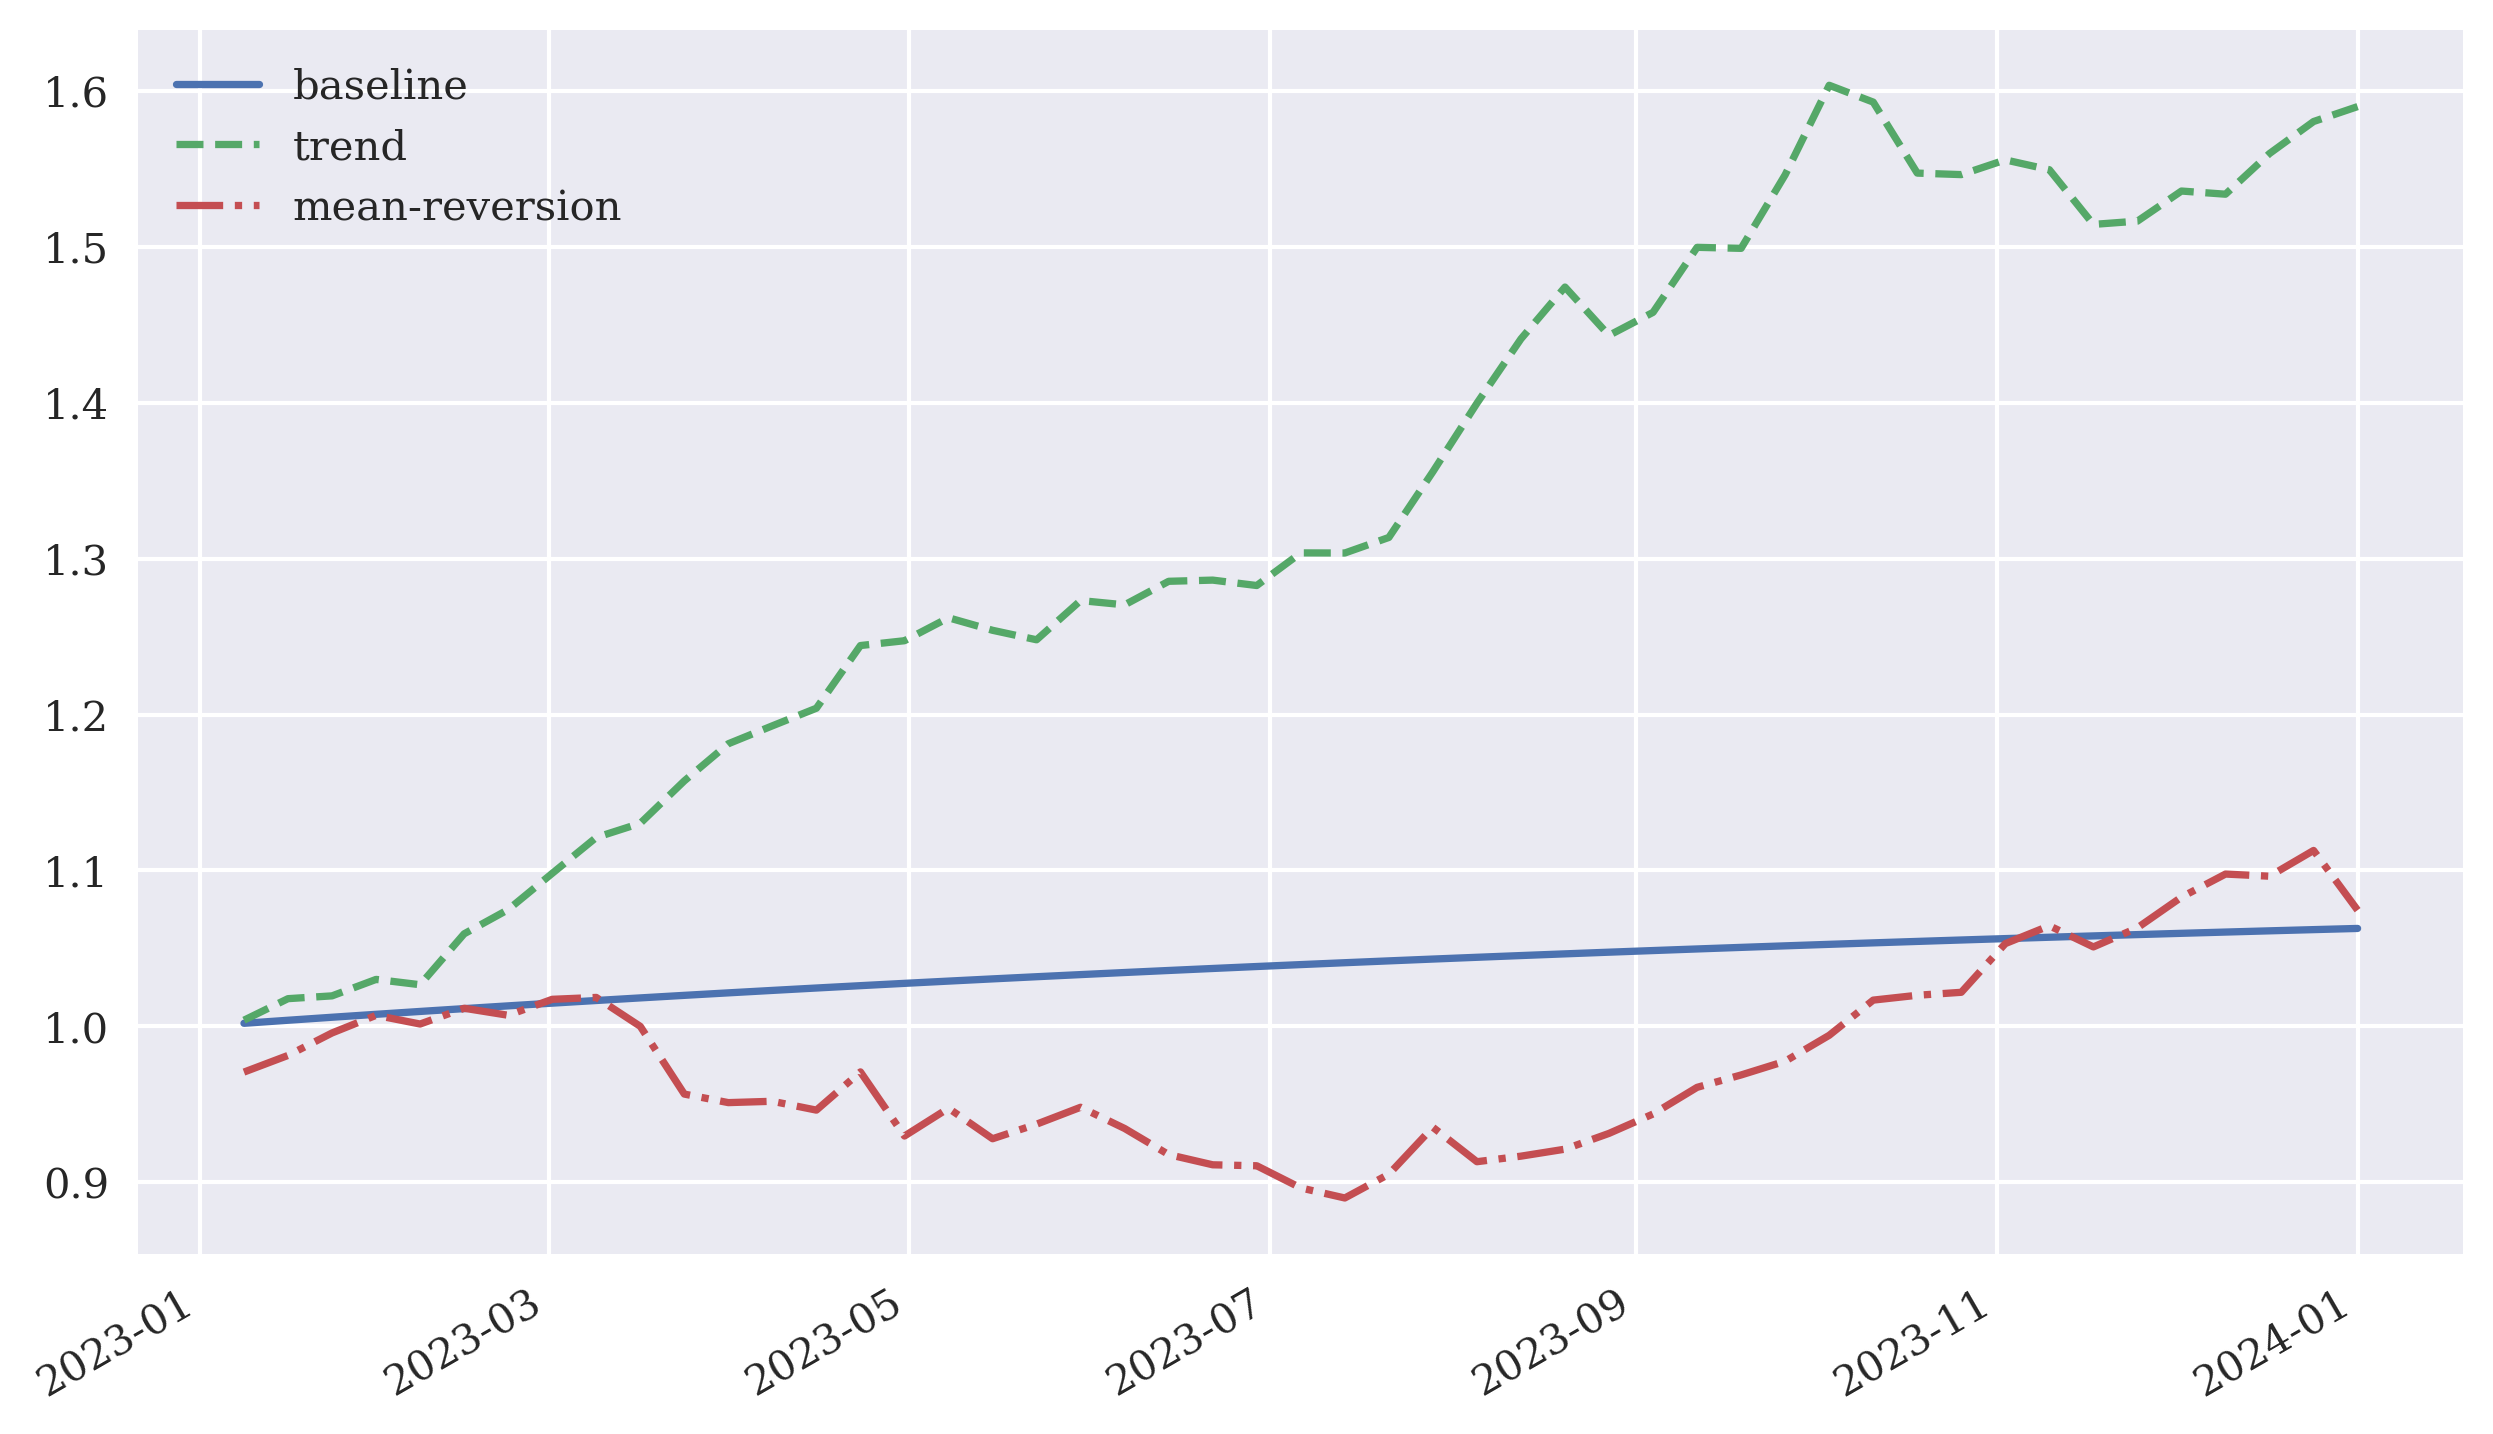

In [28]:
env_base.data[sym].plot(figsize=(10, 6),label='baseline')
env_trend.data[sym].plot(label='trend', style='--')
env_mrev.data[sym].plot(label='mean-reversion', style='-.')
plt.legend();
# plt.savefig('../figures/figure_04_02.png')

In [29]:
sim = Simulation(sym, 'r', 4, start='2023-1-1', end='2028-1-1',
                 periods=500, min_accuracy=0.6, x0=1,
                 kappa=1.25, theta=2, sigma=0.15,
                 normalize=True, new=True)

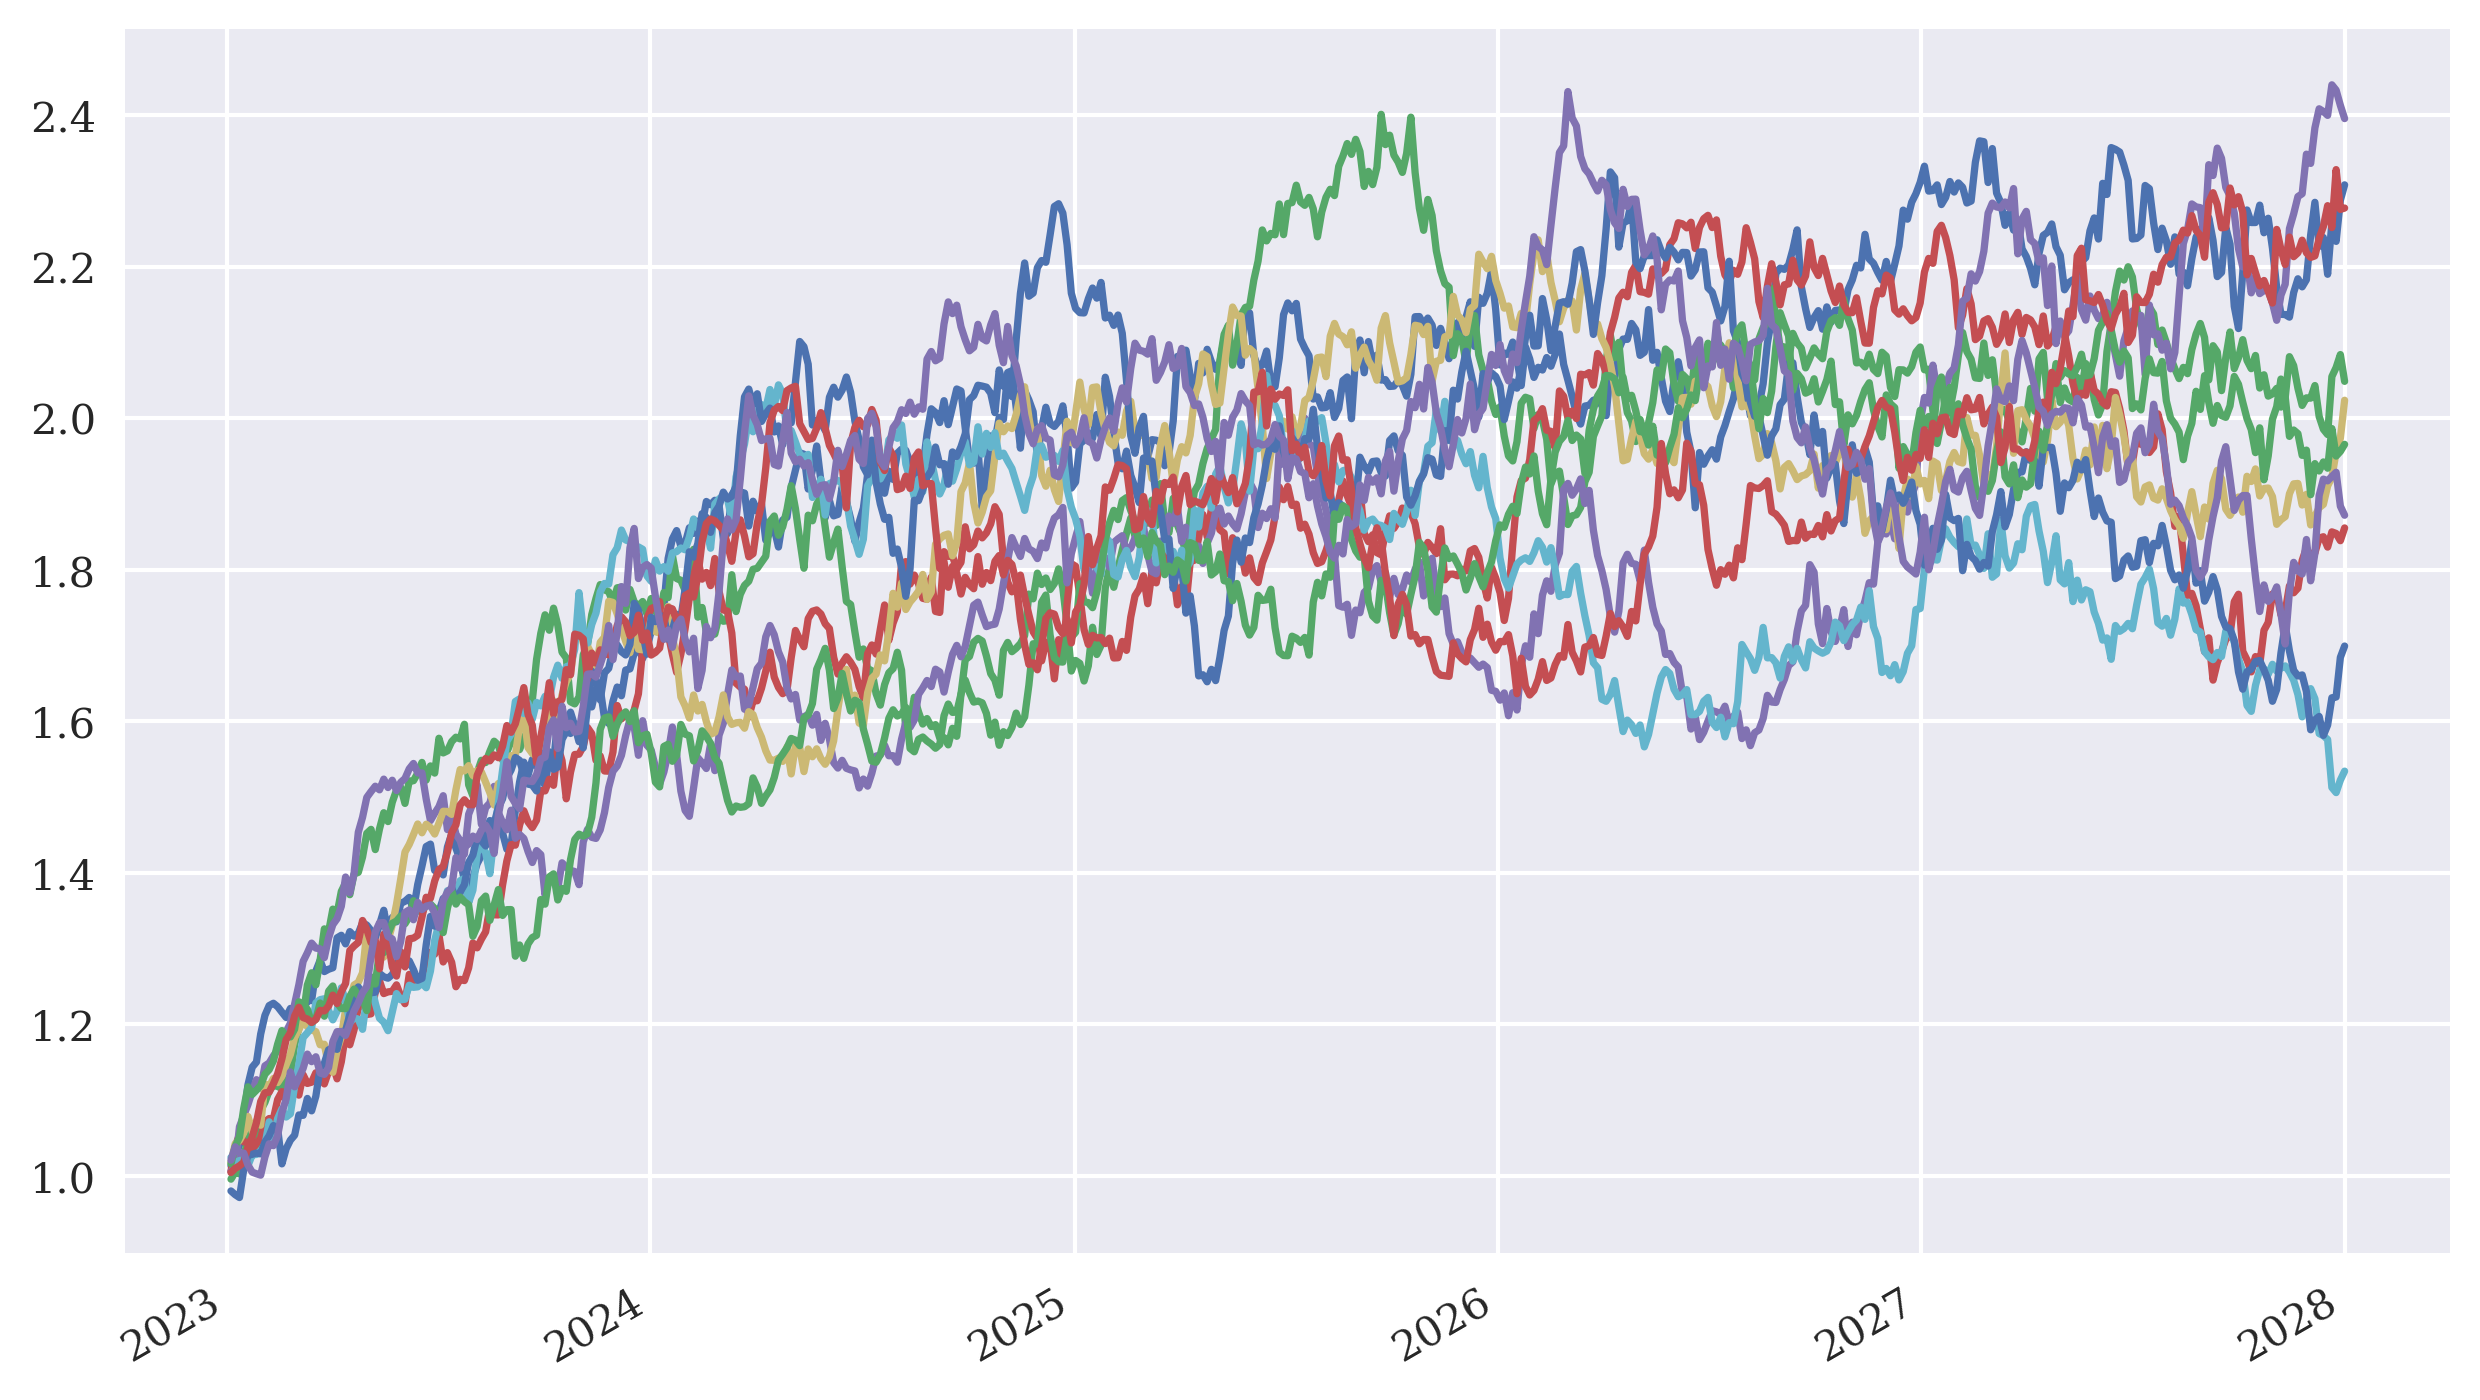

In [30]:
for _ in range(10):
    sim.reset()
    sim.data[sym].plot(figsize=(10, 6));

In [34]:
sim = Simulation(sym, 'r', 4, start='2023-1-1', end='2028-1-1',
                 periods=500, min_accuracy=0.6, x0=1,
                 kappa=1.25, theta=1, sigma=0.15,
                 normalize=True, new=True)  # <3>

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>